# Modelos de lenguaje probabilísticos: embeddings estáticos y contextualizados

Basado en <b>Notebook: embeddings-textos-breve-cacic2024.ipynb</b>

In [1]:
import logging
logging.basicConfig(level=logging.INFO) # For more information about what's happening

## 1) Representación de tokens/palabras

### 1.1) Embeddings estáticos (Glove)

**Gensim** dispone de **conjuntos de datos y modelos** gratuitos relevantes para el análisis de texto no supervisado. 

La API de Gensim permite descargar los vectores de palabras (embeddings) aprendidos con un algoritmo de aprendizaje automático.

- glove-wiki-gigaword-100: refers to a dataset commonly used in NLP and ML tasks. Specifically, it's a large-scale text corpus that combines Wikipedia articles, Gigaword news dataset, and other sources to create a massive vocabulary. The dataset is preprocessed to generate word embeddings, which are numerical representations of words that capture their semantic meaning. The "100" in the name likely indicates the size of the vocabulary or the number of dimensions used to represent each word

Para acceder a los vectores (embeddings) aprendidos por GloVe con datos de Wikipedia, tenemos que usar:

In [2]:
import gensim.downloader as api
word_vectors = api.load('glove-wiki-gigaword-100')
#Para trabajar con embeddings word2vec mas grandes:
#word_vectors = api.load('word2vec-google-news-300') 

INFO:gensim.models.keyedvectors:loading projection weights from /Users/jachicaiza/gensim-data/glove-wiki-gigaword-100/glove-wiki-gigaword-100.gz
INFO:gensim.utils:KeyedVectors lifecycle event {'msg': 'loaded (400000, 100) matrix of type float32 from /Users/jachicaiza/gensim-data/glove-wiki-gigaword-100/glove-wiki-gigaword-100.gz', 'binary': False, 'encoding': 'utf8', 'datetime': '2024-11-09T11:11:18.414067', 'gensim': '4.1.2', 'python': '3.10.8 (main, Oct 13 2022, 10:19:13) [Clang 12.0.0 (clang-1200.0.32.29)]', 'platform': 'macOS-10.15.5-x86_64-i386-64bit', 'event': 'load_word2vec_format'}


In [3]:
print(word_vectors['king'].shape)
word_vectors['king'][:20]

(100,)


array([-0.32307 , -0.87616 ,  0.21977 ,  0.25268 ,  0.22976 ,  0.7388  ,
       -0.37954 , -0.35307 , -0.84369 , -1.1113  , -0.30266 ,  0.33178 ,
       -0.25113 ,  0.30448 , -0.077491, -0.89815 ,  0.092496, -1.1407  ,
       -0.58324 ,  0.66869 ], dtype=float32)

### Visualizar la distancia entre términos según el modelo de Glove

In [4]:
import numpy as np
# Las palabras a visualizar
words = ["king", "princess", "monarch", "throne", "crown", "queen",
         "animal", "cat", "dog", "pet"]

# Obtener vectores de palabras:
vectors = np.array([word_vectors[word] for word in words]) #obtener representaciones de cada palabra

In [5]:
from sklearn.decomposition import PCA

# Reducir dimensiones (de 100 a 2 CP) usando PCA
pca = PCA(n_components=2)
vectors_pca = pca.fit_transform(vectors)

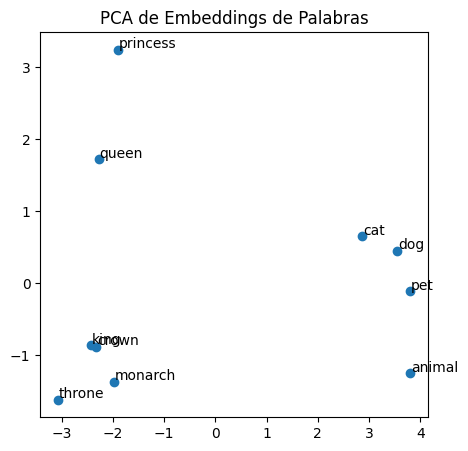

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

# Visualizar
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
axes.scatter(vectors_pca[:, 0], vectors_pca[:, 1])
for i, word in enumerate(words):
    axes.annotate(word, (vectors_pca[i, 0]+.02, vectors_pca[i, 1]+.02))
axes.set_title('PCA de Embeddings de Palabras')
plt.show()

### Recuperar los elementos más similares, según el modelo de Glove

Para consultar los embeddings usamos el método **most_similar()**.

In [7]:
word_vectors.most_similar('trump', topn=5)

[('nows', 0.5873242616653442),
 ('hilton', 0.5507662892341614),
 ('casino', 0.5180236101150513),
 ('ivanka', 0.505672812461853),
 ('mih', 0.47354456782341003)]

In [8]:
word_vectors.most_similar('obama')

[('barack', 0.937216579914093),
 ('bush', 0.927285373210907),
 ('clinton', 0.896000325679779),
 ('mccain', 0.8875633478164673),
 ('gore', 0.8000321388244629),
 ('hillary', 0.7933662533760071),
 ('dole', 0.7851964831352234),
 ('rodham', 0.7518897652626038),
 ('romney', 0.7488929629325867),
 ('kerry', 0.7472624182701111)]

In [9]:
word_vectors.most_similar('guayaquil')

[('quito', 0.8265976309776306),
 ('cuenca', 0.6952285170555115),
 ('barranquilla', 0.6634550094604492),
 ('cartagena', 0.6479460000991821),
 ('montevideo', 0.6354805827140808),
 ('maracaibo', 0.6281710863113403),
 ('barquisimeto', 0.6277834177017212),
 ('bogotá', 0.6185356974601746),
 ('pangasinan', 0.607235312461853),
 ('vladivostok', 0.5999988913536072)]

Realizando operaciones con **most_similar**: it performs vector arithmetic: adding the positive vectors, subtracting the negative, then from that resulting position, listing the known-vectors closest to that angle.

In [10]:
def analogia(x1, x2, y1):
    result = word_vectors.most_similar(positive=[y1, x2], negative=[x1])
    print(x2 + " es a " + x1 + " lo que " + result[0][0] + " es a " + y1)
    return result[0][0]

In [11]:
analogia('ecuador', 'ecuadorian', 'peru')

ecuadorian es a ecuador lo que peruvian es a peru


'peruvian'

In [12]:
analogia('australia', 'beer', 'france')

beer es a australia lo que champagne es a france


'champagne'

In [13]:
analogia('tall', 'tallest', 'long')

tallest es a tall lo que longest es a long


'longest'

También podemos ver la *palabra que no se parece a las restantes* usando el método **doesnt_match()**.

In [14]:
print(word_vectors.doesnt_match("breakfast moon dinner lunch".split()))

moon


In [16]:
print(word_vectors.doesnt_match("apple banana orange car".split()))

car


## 2. Embeddings contextualizados: Sentence-Transformers (S-BERT)

- Lista de modelos pre-entrenados: https://www.sbert.net/docs/sentence_transformer/pretrained_models.html

In [19]:
#!pip install sentence_transformers

from sentence_transformers import SentenceTransformer

# Load https://huggingface.co/sentence-transformers/all-mpnet-base-v2
model = SentenceTransformer("all-mpnet-base-v2") # sentence-transformers/all-MiniLM-L6-v2

def cosine_similarity_matrix(features):
    norms = np.linalg.norm(features, axis=1, keepdims=True)
    normalized_features = features / norms
    similarity_matrix = np.inner(normalized_features, normalized_features)
    rounded_similarity_matrix = np.round(similarity_matrix, 4)
    return rounded_similarity_matrix

messages = [
    # Asking about age
    "¿How old are you?",
    "¿How many years do you have?",
    "My name is Janneth"
]

embeddings = model.encode(messages)

sim = cosine_similarity_matrix(embeddings)
sim

INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-mpnet-base-v2
INFO:sentence_transformers.SentenceTransformer:Use pytorch device: cpu


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

array([[1.    , 0.6524, 0.1996],
       [0.6524, 1.    , 0.2351],
       [0.1996, 0.2351, 1.    ]], dtype=float32)

In [25]:
embeddings

array([[ 0.01075918,  0.00953202,  0.00184311, ...,  0.02298343,
        -0.01486466, -0.00578403],
       [-0.02574615, -0.00089829,  0.00917388, ...,  0.01658703,
        -0.0240848 , -0.02247341],
       [-0.07190469,  0.07174242, -0.00415704, ...,  0.01151347,
         0.02324641, -0.02371539]], dtype=float32)

<Axes: title={'center': 'Semantic Textual Similarity'}>

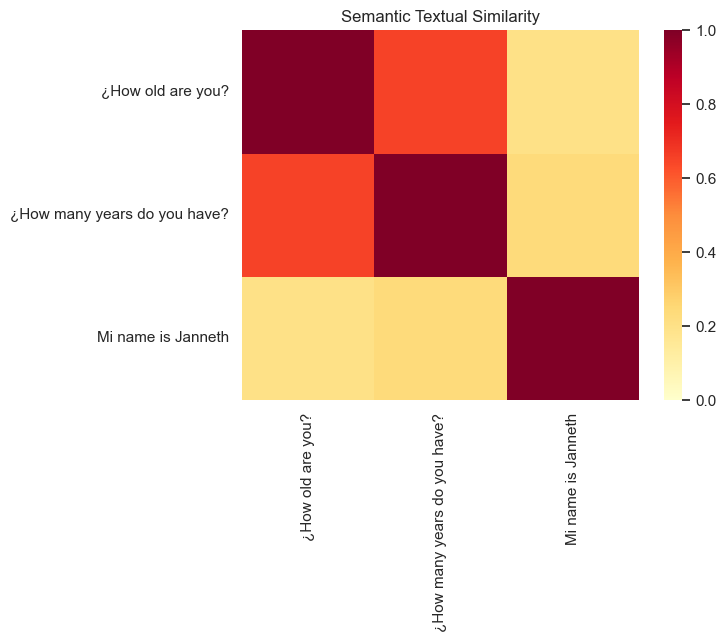

In [20]:
# Visualización:
import seaborn as sns
def plot_similarity(labels, features, rotation):
    sim = cosine_similarity_matrix(features)
    sns.set_theme(font_scale=1)
    g = sns.heatmap(sim, xticklabels=labels, yticklabels=labels, vmin=0, vmax=1, cmap="YlOrRd")
    g.set_xticklabels(labels, rotation=rotation)
    g.set_title("Semantic Textual Similarity")
    return g

plot_similarity(messages, embeddings, 90)

 ### Sentence Transformer (Multilingual)

INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: paraphrase-multilingual-MiniLM-L12-v2
INFO:sentence_transformers.SentenceTransformer:Use pytorch device: cpu


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

<Axes: title={'center': 'Semantic Textual Similarity'}>

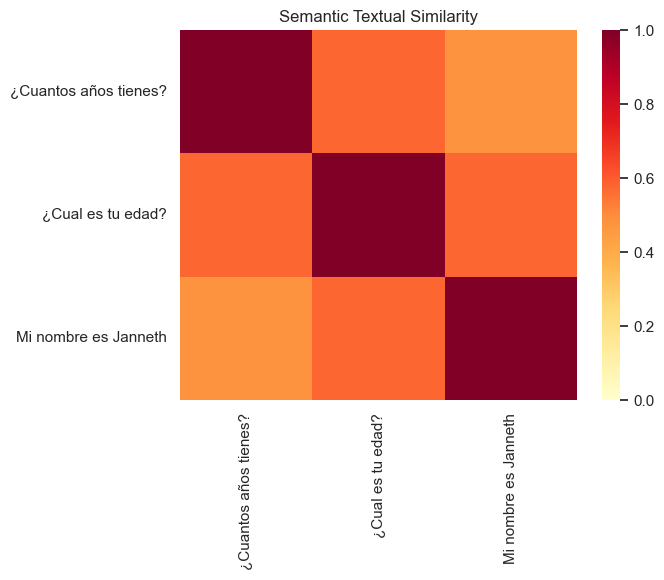

In [24]:
mensajes = [
    # Asking about age
    "¿Cuantos años tienes?",
    "¿Cual es tu edad?",
    "Mi nombre es Janneth"
]

model_m = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")  #paraphrase-multilingual-mpnet-base-v2

embeddings = model.encode(mensajes)

sim_es = cosine_similarity_matrix(embeddings)

plot_similarity(mensajes, embeddings, 90)